# Lynch Syndrome CRC calibration
Author: Sophie Wagner <br>
Contact: sw3767@cumc.columbia.edu

## Notebook configuration

In [ ]:
import sys
import os
from collections import defaultdict

import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps  # For smoothing splines
from scipy.interpolate import interp1d # For interpolation
from tqdm import tqdm  # For progress bars


sys.path.append(os.path.abspath("../src"))

# Remove previously imported modules to ensure fresh imports
for m in ["helpers", "calibration", "configs"]:
    if m in sys.modules:
        del sys.modules[m]

import helpers
import configs.global_configs as c
import configs.inputs as inputs
import helpers.common_functions as func

# Some aesthetic options
helpers.add_cell_timer()
np.set_printoptions(
    suppress=True, linewidth=300, formatter={"float": "{: 0.9f}".format}
)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Load inputs

In [2]:
# Lifetables (monthly ACM rate in 5-year age groups)
lt_f = inputs.lt_5y["prob_death_female_m"].iloc[4:17]
lt_m = inputs.lt_5y["prob_death_male_m"].iloc[4:17]
lt_f = func.probtohaz(np.array(lt_f))
lt_m = func.probtohaz(np.array(lt_m))

starting_pop = np.zeros((c.n_sexes, c.n_genes, c.n_states, 1))
starting_pop[:,:,0,:] = c.POPULATION_SIZE


### Targets

In [3]:
# NCCN: Target incidence RANGE by age 80. By Gene. 
target_inc_80 = inputs.incidence_by_80_target 

# NCCN: Cumulative CRC incidence through age 70, by gene and sex (no prob_matrixMS2)
target_inc_70 = inputs.incidence_by_70_target

# NCCN: Median age at CRC diagnosis. Range for MSH6 and prob_matrixMS2, value for MLH1 and MSH2. all sexes. 
target_median_age = inputs.median_age_at_dx_target

# Stage distribution (ensure 4-long vector in stage_1..stage_4 order)
target_stage_dist = (
    inputs.stage_dist_target
    .sort_values("stage")["value"]
    .to_numpy()
)

# (Myles) Adenoma by 65. by gene, all sexes
target_polyp = inputs.polyp_target

# (Mecklin) Adenoma cumulative risk to age 70 by sex, all genes
target_polyp_cuminc = inputs.polyp_cumulative_target

# (Dominguez) Target incidence by age 65. By Sex and Gene. UNDER SURVEILLANCE
target_inc_65 = inputs.incidence_by_65_target

# (Dominguez) CRC cumulative incidence rate UNDER SURVEILLANCE by gene and sex and age. 
# This should inform the curve/slope of development, values of model may be skewed more to the NCCN targets. 
# CRC incidence [30,40,50,60,75]
target_inc_cumulative = inputs.incidence_cumulative_target
# Access like: target_inc_cumulative.loc[('MLH1','female')]
# CRC incidence curve (diffs bt [30-40,40-50,50-60,60-70,70-75])
target_inc_curve = inputs.incidence_cumulative_curve_target
# Access like: target_inc_curve.loc[('MLH1','female')]

# (Governe) First colo checkpoint -- risk for CRC, adenoma, adv adenoma. By gene, all sexes
target_first_colo = inputs.first_colo_target

# (Source) Polyp dwell time. By gene, all sexes
target_polyp_dwell_time = inputs.adn_dwell_target

In [4]:
print("Target inc 80-------------------------------------")
print(target_inc_80)
print("\nTarget inc 70-----------------------------------")
print(target_inc_70)
print("\nTarget inc 65-----------------------------------")
print(target_inc_65)
print("\nTarget cumulative inc---------------------------")
print(target_inc_cumulative)
print("\nTarget cumulative inc curve---------------------")
print(target_inc_curve.head())
print("\nTarget median age-------------------------------")
print(target_median_age)
print("\nTarget polyp prevalence 65----------------------")
print(target_polyp)
print("\nTarget cumulative polyp risk--------------------")
print(target_polyp_cuminc.head())
print("\nTarget first colo checkpoint--------------------")
print(target_first_colo)
print("\nDwell time objectives---------------------------")
print(target_polyp_dwell_time)
print("\nTarget stage distribution---------------------")
print(target_stage_dist)

Target inc 80-------------------------------------
      lower  upper  ref
gene                   
MLH1  0.460   0.61  103
MSH2  0.330   0.52  103
MSH6  0.100   0.44  103
PMS2  0.087   0.20  103

Target inc 70-----------------------------------
             value  lower  upper        se       var
gene sex                                            
MLH1 male    0.439  0.396  0.466  0.017857  0.000319
MSH2 male    0.539  0.490  0.563  0.018622  0.000347
MSH6 male    0.120  0.024  0.246  0.056633  0.003207
MLH1 female  0.373  0.322  0.402  0.020408  0.000416
MSH2 female  0.386  0.341  0.420  0.020153  0.000406
MSH6 female  0.123  0.035  0.232  0.050255  0.002526

Target inc 65-----------------------------------
             value  lower  upper        se       var     n
gene sex                                                  
MLH1 male    0.484  0.424  0.548  0.031633  0.001001  1445
MSH2 male    0.415  0.348  0.488  0.035714  0.001276  1463
MSH6 male    0.127  0.068  0.231  0.041582  0

## Matrix configuration

In [21]:
def create_matrix() -> np.ndarray:
    """
    Initializes matrix SEXES x GENES x AGES x N_STATES x N_STATES
    This gives us an N_STATES x N_STATES matrix for each age layer for each gene-gender combination
    Each item in the matrix is a HAZARD rate (not probability)
    """
    
    matrix = np.zeros(
        (len(c.SEXES), len(c.GENES), len(c.AGE_LAYERS), c.n_states, c.n_states)
    )
    H, LR, HR, U1, U2, U3, U4, D1, D2, D3, D4 = c.alive_states_idx
    matrix[:, c.GENE2IDX['MLH1'], :, H, LR] = func.probtohaz(0.06123)  # healthy to lr_polyp
    matrix[:, c.GENE2IDX['MSH2'], :, H, LR] = func.probtohaz(0.08009)  # healthy to lr_polyp
    matrix[:, c.GENE2IDX['MSH6'], :, H, LR] = func.probtohaz(0.06111)  # healthy to lr_polyp
    matrix[:, c.GENE2IDX['PMS2'], :, H, LR] = func.probtohaz(0.06111)  # healthy to lr_polyp
    
    matrix[:, c.GENE2IDX['MLH1'], :, LR, HR] = func.probtohaz(0.31432)  # lr_polyp to hr_polyp
    matrix[:, c.GENE2IDX['MSH2'], :, LR, HR] = func.probtohaz(0.37686)  # lr_polyp to hr_polyp
    matrix[:, c.GENE2IDX['MSH6'], :, LR, HR] = func.probtohaz(0.19450)  # lr_polyp to hr_polyp
    matrix[:, c.GENE2IDX['PMS2'], :, LR, HR] = func.probtohaz(0.19450)  # lr_polyp to hr_polyp
    
    matrix[:, c.GENE2IDX['MLH1'], :, HR, U1] = func.probtohaz(0.81975)  # hr_polyp to u_CRC
    matrix[:, c.GENE2IDX['MSH2'], :, HR, U1] = func.probtohaz(0.57648)  # hr_polyp to u_CRC
    matrix[:, c.GENE2IDX['MSH6'], :, HR, U1] = func.probtohaz(0.44156)  # hr_polyp to u_CRC
    matrix[:, c.GENE2IDX['PMS2'], :, HR, U1] = func.probtohaz(0.44156)  # hr_polyp to u_CRC
    
    matrix[:, :, :, U1, U2] = func.probtohaz(0.2)  # u_CRC to d_CRC
    matrix[:, :, :, U2, U3] = func.probtohaz(0.4)  # u_CRC to d_CRC
    matrix[:, :, :, U3, U4] = func.probtohaz(0.5)  # u_CRC to d_CRC
    
    matrix[:, :, :, U1, D1] = func.probtohaz(0.3)  # u_CRC to d_CRC
    matrix[:, :, :, U2, D2] = func.probtohaz(0.5)  # u_CRC to d_CRC
    matrix[:, :, :, U3, D3] = func.probtohaz(0.6)  # u_CRC to d_CRC 
    matrix[:, :, :, U4, D4] = func.probtohaz(0.7)  # u_CRC to d_CRC

    matrix = add_acm(matrix)  # ACM
    matrix = constrain_matrix(matrix)  # constrain

    return matrix


def constrain_matrix(matrix):
    EPS = 1e-10
    H, LR, HR, U1, U2, U3, U4, D1, D2, D3, D4 = c.alive_states_idx
    
    # Progression ---
    matrix[:, :, :, H, LR] = np.maximum(EPS, matrix[:, :, :, H, LR])  # not below 0
    matrix[:, :, :, LR, HR] = np.maximum(matrix[:, :, :, LR, HR], matrix[:, :, :, H, LR])
    matrix[:, :, :, HR, U1] = np.maximum(matrix[:, :, :, HR, U1], matrix[:, :, :, LR, HR])
    matrix[:, :, :, U1, U2] = np.maximum(matrix[:, :, :, U1, U2], matrix[:, :, :, HR, U1])
    matrix[:, :, :, U2, U3] = np.maximum(matrix[:, :, :, U2, U3], matrix[:, :, :, U1, U2])
    matrix[:, :, :, U3, U4] = np.maximum(matrix[:, :, :, U3, U4], matrix[:, :, :, U3, U4])
    
    # u_CRC to d_CRC ---
    matrix[:, :, :, U1, D1] = np.maximum(EPS, matrix[:, :, :, U1, D1])  # not below 0
    matrix[:, :, :, U2, D2] = np.maximum(matrix[:, :, :, U2, D2], matrix[:, :, :, U1, D1])
    matrix[:, :, :, U3, D3] = np.maximum(matrix[:, :, :, U3, D3], matrix[:, :, :, U2, D2])
    matrix[:, :, :, U4, D4] = np.maximum(matrix[:, :, :, U4, D4], matrix[:, :, :, U3, D3])

    # Age dependency --- 
    matrix[:, :, :, H, LR] = np.maximum.accumulate(matrix[:, :, :, H, LR], axis=2) # healthy to lr_polyp
    
    return matrix


def add_acm(matrix):
    idx_ACM = c.health_states_stoi["death_all_cause"]
    for sex, lt in enumerate([lt_m, lt_f]):
        matrix[sex, :, :, c.alive_states_idx, idx_ACM] = lt[None, None, :]
        matrix[sex, :, :, idx_ACM, :] = 0.0  # Stay in ACM
    return matrix


def add_csd(matrix):
    idx_CRC = c.detected_states_idx
    idx_CSD = c.health_states_stoi["death_cancer"]
    matrix[:, :, :, idx_CRC, idx_CSD] = func.probtohaz(0.15)
    matrix[:, :, :, idx_CSD, :] = 0.0 # Stay in CSD
    return matrix

## Markov model

In [6]:
def hazards_to_probs(H, dt=1.0):
    """Competing-risk map: monthly hazards -> monthly transition probabilities."""
    H = np.clip(np.asarray(H, float), 0.0, None)            # (..., N, N)
    lam_tot = H.sum(axis=-1, keepdims=True)                 # (..., N, 1) sum over j
    stay = np.exp(-lam_tot * dt)                            # (..., N, 1)
    p_leave = 1.0 - stay                                    # (..., N, 1)

    # distribute leave prob across destinations by hazard fraction
    with np.errstate(divide='ignore', invalid='ignore'):
        frac = np.where(lam_tot > 0, H / lam_tot, 0.0)      # (..., N, N)
    P = frac * p_leave                                      # (..., N, N)

    # put the stay prob on the diagonal
    N = H.shape[-1]
    idx = np.arange(N)
    P[..., idx, idx] = P[..., idx, idx] + stay[..., idx, 0]
    return P


In [7]:
def run_markov(tmatH, starting_age=20, max_age=84):
    
    current_age = starting_age
    stage, age_layer_idx = 1, 0
    pop_log   = starting_pop.copy()  # (2, G, N, 1) at t=0
    month_pop = starting_pop.copy() # (2, G, N, 1) at t=0
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    n_years = max_age - starting_age + 1 

    # Initial matrix is (2, G, A, N, N) (SEX, GENE, AGE_GROUP, HEALTH_STATE, HEALTH_STATE)
    # 1) Convert from hazards to probs
    # 2) Transpose health state sub-matrix s.t. we get inverted matrix for multiplication
    # 3) Get inflow matrix (lower triangle)
    
    tmatP = np.empty_like(tmatH, dtype=float)
    S, G, A, N, _ = tmatH.shape
    for s in range(S):
        for g in range(G):
            for a in range(A): 
                tmatP[s,g,a] = hazards_to_probs(tmatH[s,g,a])
    tmatP_T = tmatP.transpose(0,1,2,4,3) # (2, G, A, to, from)
    inflow_tmatP = np.tril(tmatP_T, k=-1) # lower triangle, exclude diag -> inflows
    
    while current_age <= max_age:
        
        # Matrix multiplication (state transition)
        # Shape: (2, G, N, N) x (2, G, N, 1) -> (2, G, N, 1)
        month_inc = np.matmul(inflow_tmatP[:,:,age_layer_idx,:,:], month_pop)  
        month_pop = np.matmul(tmatP_T[:,:,age_layer_idx,:,:], month_pop) 
        
        # append along time axis
        inc_log = np.concatenate((inc_log, month_inc), axis=3)  # (2,G,N,T)
        pop_log = np.concatenate((pop_log, month_pop), axis=3)  # (2,G,N,T)
        
        stage += 1
        
        if stage % 12 == 0:
            current_age += 1
            new_idx = ((current_age - c.START_AGE) // 5)
            if new_idx != age_layer_idx and 0 <= new_idx < A:
                age_layer_idx = int(new_idx)

    # Adjustment: incidence and prevalence should be out of living only
    # sum over STATE axis (axis=2) to get (sex, gene, time)
    dead_counts = pop_log[:, :, c.death_states_idx, :].sum(axis=2)  # (2, G, T)
    alive = np.maximum(c.POPULATION_SIZE - dead_counts, 1e-12)  # (2, G, T)
    dead_factor = (c.POPULATION_SIZE / alive)                   # (2, G, T)
    
    prevalence_adj = np.zeros_like(pop_log)  # (2, G, N, T)
    incidence_adj, incidence_unadj = inc_log.copy(), inc_log.copy() # both (2,G,N,T)

    for state in range(c.n_states):
        incidence_adj[:, :, state, :]  = inc_log[:, :, state, :]  * dead_factor
        prevalence_adj[:, :, state, :] = pop_log[:, :, state, :]  * dead_factor

    # Transform into annual counts. For incidence, we sum; for prevalence, we average. 
    incidence_unadj = incidence_unadj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).sum(axis=-1) # getting inc unadjusted
    incidence_adj   = incidence_adj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).sum(axis=-1) # getting annual incidence (rate per 100k alive)
    prevalence_adj  = prevalence_adj.reshape(c.n_sexes, c.n_genes, c.n_states, n_years, 12).mean(axis=-1) # getting mean annual prevalence
    
    return incidence_adj, prevalence_adj, incidence_unadj, pop_log

## Calibration

### Step function
1. Select random combination of (sex, gene, age layer, transition prob)
2. Take a random step (using step size) to adjust the selected transition probability
3. (Optional / later into calibration) Spline across age groups such that we don't get too abnormal of a value / smoother transitions across age
4. Check matrix constraints

In [50]:
calibration_tps = list(c.calibration_tps_itos.keys())
n_calibration_tps = len(calibration_tps)
age_mids = [22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5]
n_probs = c.n_age_layers * c.n_sexes * c.n_genes * n_calibration_tps
n_adj = int(min(30,n_probs * 0.05))
EPS = 1e-8

def step(matrix, step_size, num_adj=n_adj, smooth=0.01):
    new_matrix = np.copy(matrix)
    step_tp = np.random.choice(n_calibration_tps, size=num_adj, replace=True)
    step_age = np.random.choice(c.n_age_layers, size=num_adj, replace=True)
    step_sex = np.random.choice(c.n_sexes, size=num_adj, replace=True)
    step_gene = np.random.choice(c.n_genes, size=num_adj, replace=True)
    H, LR, HR = (c.health_states_stoi[key] for key in ["healthy","lr_polyp","hr_polyp"])
        
    for i in range(num_adj):
        (from_state, to_state) = calibration_tps[step_tp[i]]
        if (from_state,to_state) in [(H,LR),(LR,HR)]: # only Healthy -> LR -> HR may differ across sex
            s = matrix[step_sex[i], step_gene[i], step_age[i], from_state, to_state] * step_size # proportional to TP 
            new_matrix[step_sex[i], step_gene[i], step_age[i], from_state, to_state] += np.random.uniform(low=-s, high=s)
        else:
            s = matrix[:, step_gene[i], step_age[i], from_state, to_state].mean() * step_size
            new_matrix[:, step_gene[i], step_age[i], from_state, to_state] += np.random.uniform(low=-s, high=s)

    # Limit potential increase before splining across ages 
    new_matrix[:,:,c.n_age_layers-1,:,:] = np.minimum(new_matrix[:,:,c.n_age_layers-2,:,:],new_matrix[:,:,c.n_age_layers-1,:,:])  
    new_matrix = csaps(age_mids, new_matrix, smooth=smooth, axis=2)(age_mids).clip(EPS, None)
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)

    return new_matrix

### Objective function (goodness of fit)
Here, we calculate how far off we are from our model targets, and produce a goodness-of-fit score. This is calculated by the mean-squared error between the model output and the target (i.e. mean((prediction-target)**2)). Our calibration targets are:
1. Stage distribution at diagnosis -- from Myles
2. Cumulative CRC incidence by gene and sex -- from Dominguez et al 2024 splined curves (see "data cleaning" folder)
3. Cumulative adenoma risk by gene at age 60 -- from Myles

#### Obj

In [56]:
# --- small helpers ------------------------------------------------------------

EPS = 1e-9

H, LR, HR, U1, U2, U3, U4, D1, D2, D3, D4 = c.alive_states_idx
IDX_UCRC = [U1, U2, U3, U4]
IDX_DCRC = [D1, D2, D3, D4]

# Target stage distribution--------------------
# [ 0.400000000  0.360000000  0.190000000  0.050000000]
def obj_stage_weighted(log):
    """
    Loss for stage distribution, per gene and sex, weighted by CRC count at each age.
    Returns: loss_per_gene: (G,)
    """
    inc_unadj = log[2]  # (S, G, N_states, A)

    # Keep only CRC stages, keep sex separate
    stage_totals_per_age = inc_unadj[:, :, IDX_DCRC, :] # (S, G, 4, A)

    # Total CRC per (sex, gene, age)
    total_crc_per_age = stage_totals_per_age.sum(axis=2)  # (S, G, A)
    denom = np.maximum(total_crc_per_age[:, :, None, :], EPS)  # (S, G, 1, A)

    # Stage proportions per (sex, gene, age)
    stage_props = stage_totals_per_age / denom  # (S, G, 4, A)

    # Per-age MSE vs target over the 4 stages → mean over axis=2
    per_age_mse = ((stage_props - target_stage_dist[None, None, :, None])**2).mean(axis=2)  # (S, G, A)

    # Age weights per (sex, gene): sum over age = 1
    age_weights = total_crc_per_age / np.maximum(total_crc_per_age.sum(axis=2, keepdims=True), EPS)  # (S, G, A)

    # Sex-specific, gene-level loss: weighted sum over age
    loss_sg = (age_weights * per_age_mse).sum(axis=2)  # (S, G)

    # Combine sexes. Weight by total CRC counts per (sex, gene) so higher-count sex gets more influence.
    sex_weights = total_crc_per_age.sum(axis=2)  # (S, G)
    sex_weights = sex_weights / np.maximum(sex_weights.sum(axis=0, keepdims=True), EPS)  # (S, G)

    loss_per_gene = (sex_weights * loss_sg).sum(axis=0)  # (G,)

    return loss_per_gene


# Helper function
def mse(target, model, map_pms2_to_msh6=False):
    """
    Calculate MSE for the incidence targets indexed by sex and gene. 
    Used in obj_inc_by_70, obj_inc_by_65, and obj_inc_cumulative_to_75
    """
    if not "value" in target.columns:
        raise ValueError("target must have column value")

    if not isinstance(target.index, pd.MultiIndex) or list(target.index.names) != ["gene","sex"]:
        target = target.set_index(["gene","sex"])  # no-op if already indexed
    
    loss = np.zeros(c.n_genes)
    for g, gene in enumerate(c.GENES):
        local_gene = ("MSH6" if (map_pms2_to_msh6 and gene == "PMS2") else gene)
        for s, sex in enumerate(c.SEXES):
            row = target.loc[(local_gene, sex)]
            val = row["value"]
            
            se  = 1.0 if not "se" in row.index else max(row["se"], EPS)
            n = row["n"] if "n" in row.index else None
            
            # optional 1/sqrt(n) weight
            if n is not None and func.isfinite(n) and n > 0:
                w = 1.0 / float(np.sqrt(n))
            else:
                w = 1.0

            loss[g] += w * ((model[s, g] - val) / se) ** 2
    return loss

# --- objectives ---------------------------------------------------------------

# Target inc 80-------------------------
#       lower  upper  ref
# gene                   
# MLH1  0.460   0.61  103
# MSH2  0.330   0.52  103
# MSH6  0.100   0.44  103
# PMS2  0.087   0.20  103
def obj_inc_by_80(log):
    """
    Hinge loss to keep total cumulative incidence by 80 within [lower, upper].
    Compare proportions across both sexes combined.
    """
    inc_unadj = log[2]
    age_80 = func.age_to_idx(80)
    
    model_inc_80 = np.zeros(c.n_genes, dtype=float)
    for state in IDX_DCRC:
        model_inc_80 += func.cumulative_cases_to_age(inc_unadj, age_80, state_idx=state,
                                    sum_over=("sex","age")) # (gene,) as proportion of pop

    loss = np.zeros(c.n_genes)
    for g, gene in enumerate(c.GENES):
        row = target_inc_80.loc[gene]
        lo, hi = row["lower"], row["upper"]
        var = ((hi - lo) / (2*1.96))**2  # CI->variance
        loss[g] = func.w_hinge(model_inc_80[g], lo, hi, var=var)
    return loss


# Target inc 70-------------------------
#              value  lower  upper        se       var
# gene sex                                            
# MLH1 male    0.439  0.396  0.466  0.017857  0.000319
# MSH2 male    0.539  0.490  0.563  0.018622  0.000347
# MSH6 male    0.120  0.024  0.246  0.056633  0.003207
# MLH1 female  0.373  0.322  0.402  0.020408  0.000416
# MSH2 female  0.386  0.341  0.420  0.020153  0.000406
# MSH6 female  0.123  0.035  0.232  0.050255  0.002526
def obj_inc_by_70(log):
    """
    Cumulative CRC incidence by age 70 by sex and gene.
    Target: Wang (NCCN)
    """
    inc_unadj = log[2]
    age_70 = func.age_to_idx(70)
    
    model_inc_70 = np.zeros((c.n_sexes, c.n_genes))
    for state in IDX_DCRC:
        model_inc_70 += func.cumulative_cases_to_age(inc_unadj, age_70, state, sum_over=("age",)) # (sex,gene)
    return mse(target=target_inc_70, model=model_inc_70, map_pms2_to_msh6=True)


# Target inc 65-------------------------
#              value  lower  upper        se       var     n
# gene sex                                                  
# MLH1 male    0.484  0.424  0.548  0.031633  0.001001  1445
# MSH2 male    0.415  0.348  0.488  0.035714  0.001276  1463
# MSH6 male    0.127  0.068  0.231  0.041582  0.001729   765
# PMS2 male    0.095  0.025  0.329  0.077551  0.006014   239
# MLH1 female  0.363  0.310  0.423  0.028827  0.000831  1686
# MSH2 female  0.298  0.246  0.358  0.028571  0.000816  1708
# MSH6 female  0.101  0.050  0.171  0.030867  0.000953   884
# PMS2 female  0.028  0.004  0.182  0.045408  0.002062   310
def obj_inc_by_65(log):
    """
    Cumulative CRC incidence through age 65 by sex and gene.
    Target: Dominguez 2023 (PLSD)
    """
    inc_unadj = log[2]
    age_65 = func.age_to_idx(65)
    
    model_inc_65 = np.zeros((c.n_sexes, c.n_genes))
    for state in IDX_DCRC:
        model_inc_65 += func.cumulative_cases_to_age(inc_unadj, age_65, state, sum_over=("age",)) # (sex,gene)

    return mse(target=target_inc_65, model=model_inc_65)


# Target cumulative inc------------------------
#                  value  lower  upper     n        se       var
# gene sex    age                                               
# MLH1 female 30   0.000    NaN    NaN  1686  0.041934  0.001758
#             40   0.090  0.063  0.128  1686  0.016582  0.000275
#             50   0.182  0.145  0.228  1686  0.021173  0.000448
#             60   0.306  0.258  0.361  1686  0.026276  0.000690
#             70   0.421  0.362  0.486  1686  0.031633  0.001001
def obj_inc_cumulative_to_75(log):
    """
    Match PLSD cumulative points at ages [30,40,50,60,70,75] by sex.
    Controls curve *shape* with a Huber penalty on adjacent increments.
    """
    inc_unadj = log[2]
    loss = np.zeros(c.n_genes)
    
    # Incidence loss
    ages = np.array([30, 40, 50, 60, 70, 75])
    age_idxs = (ages - c.START_AGE).astype(int)
    
    model_cum_inc = np.zeros((c.n_sexes, c.n_genes, inc_unadj.shape[-1]))
    for state in IDX_DCRC:
        model_cum_inc += func.cumsum_cases(inc_unadj, state) # (sex, gene,age)

    for age, age_idx in zip(ages, age_idxs):
        target_age = target_inc_cumulative[target_inc_cumulative["age"]==age]
        model_age = model_cum_inc[:,:,age_idx]
        loss += mse(target_age, model_age) / len(ages)
    
    # Shape loss
    ages = ages[1:]
    model_cum_diff = np.diff(model_cum_inc[:,:,age_idxs],axis=2)
    age_idxs = np.arange(len(ages))
    
    for age, age_idx in zip(ages, age_idxs):
        target_age = target_inc_curve[target_inc_curve["age"]==age]
        model_age = model_cum_diff[:,:,age_idx]
        loss += mse(target_age, model_age) / len(ages)
        
    return loss


# Target median age------------------------------
#       value  lower  upper  refs
# gene                           
# MLH1   44.0    NaN    NaN   103
# MSH2   44.0    NaN    NaN   103
# MSH6    NaN   42.0   69.0   103
# PMS2    NaN   61.0   66.0   103
def obj_median_age_dx(log):
    """
    Median age of incident CRC across both sexes, compared to gene-specific target:
      - MLH1/MSH2: fixed value
      - MSH6/PMS2: range [lower, upper]
    """
    inc_unadj = log[2]
    inc_curve = inc_unadj[:, :, IDX_DCRC, :].sum(axis=(0,2))   # (gene, age)
    ages = np.arange(c.START_AGE, c.START_AGE + inc_curve.shape[1])

    loss = np.zeros(c.n_genes)
    for g, gene in enumerate(c.GENES):
        w = inc_curve[g, :]
        if w.sum() <= 0:
            loss[g] = 0.0
            continue
        cdf = np.cumsum(w) / np.sum(w)
        model_med = float(np.interp(0.5, cdf, ages))

        row = target_median_age.loc[gene]
        val, lo, hi = row.get("value"), row.get("lower"), row.get("upper")
        if func.isfinite(val):
            loss[g] = (model_med - float(val))**2
        else:
            loss[g] = func.w_hinge(model_med,
                              float(lo) if func.isfinite(lo) else None,
                              float(hi) if func.isfinite(hi) else None)
    return loss

# Target polyp prevalence (age 60)---------------------
#        value
# gene        
# MLH1  0.6809
# MSH2  0.5836
# MSH6  0.6181
# PMS2  0.6181
def obj_polyp_by_60(log):
    """
    Polyp prevalence by age 60, by gene only. Only checking LR because must go thru LR to get HR.
    Target: Myles source
    """
    inc_unadj = log[2]
    age_60 = func.age_to_idx(60)
    loss = np.zeros(c.n_genes)

    # Get inc (prop) for lr and hr polyp (gene,)
    inc_lr = func.cumulative_cases_to_age(inc_unadj, age_60, LR) 
    
    for g, gene in enumerate(c.GENES):
        target_val = target_polyp.loc[gene, "value"]
        loss[g] = (inc_lr[g] - target_val) ** 2
    
    return loss

# Target cumulative polyp prevalence (to age 70)---------------------
# sex,age,value,lower,upper,se,var
# female,20,0.016533279977835994,0.0,0.07376506518324581,0.0722897638795809,0.005225809961765559
# female,21,0.029151225188216556,0.0,0.10238681949689107,0.10033908310695325,0.01006793159874407
# female,22,0.04160216757053817,0.0,0.1302634721420187,0.12765820269917832,0.0162966167163845
# female,23,0.05371910429674188,0.0,0.15664992145011103,0.1535169230211088,0.02356744565386905
# female,24,0.06533503253876875,0.0,0.18080106575265048,0.17718504443759747,0.03139453997235339
# female,25,0.0762833113991931,0.0,0.2019844354150529,0.19794474670675183,0.03918212274880014
def obj_polyp_cumulative_to_70(log):
    inc_unadj = log[2]
    age_70 = func.age_to_idx(70)
    loss = np.zeros(c.n_genes)
    
    # Get inc (prop) for lr and hr polyp (sex, age)
    inc_lr = func.cumsum_cases(inc_unadj, LR, sum_over=("gene",)) 
    diff = 0.0
    for s, sex in enumerate(c.SEXES):
        target_val = target_polyp_cuminc.loc[sex,"value"].to_numpy() # type: ignore
        target_se = target_polyp_cuminc.loc[sex,"se"].to_numpy() # type: ignore
        model_val = inc_lr[s,:age_70+1] # inclusive
        diff += np.mean(((model_val-target_val)/target_se)**2) # type: ignore
    
    loss += diff / c.n_genes
    return loss
    

# Target first colo checkpoint ------------------------------
#       p_aden  se_aden   p_adv  se_adv   p_crc  se_crc      n  med_age
# gene                                                                 
# MLH1  0.2727   0.0601  0.1455  0.0475  0.0545  0.0306   55.0     38.0
# MSH2  0.2273   0.0633  0.0909  0.0433  0.0227  0.0225   44.0     39.0
# MSH6  0.2587   0.0366  0.1189  0.0271  0.0280  0.0138  143.0     49.0
# PMS2  0.3636   0.0272  0.1818  0.0822  0.0140  0.0444   22.0     50.0
def obj_first_colo_loss(log, weight="n"):
    """
    Fit polyp and CRC prevalence at Goverde 2020 "first colo" rates.
    """
    inc_unadj = log[2]
    loss = np.zeros(c.n_genes)

    for g, gene in enumerate(c.GENES):
        row = target_first_colo.loc[gene]
        med_idx = func.age_to_idx(row["med_age"])

        p_aden = func.cumulative_cases_to_age(inc_unadj[:, g, ...], med_idx, LR)
        p_adv  = func.cumulative_cases_to_age(inc_unadj[:, g, ...], med_idx, HR)
        
        p_crc = np.zeros_like(p_aden, dtype=float)
        for state in IDX_DCRC:
            p_crc  += func.cumulative_cases_to_age(inc_unadj[:, g, ...], med_idx, state)

        pred = np.array([p_aden, p_adv, p_crc], dtype=float)
        obs  = np.array([row['p_aden'], row['p_adv'], row['p_crc']], dtype=float)
        se   = np.maximum(np.array([row['se_aden'], row['se_adv'], row['se_crc']], dtype=float), 1e-6)

        base = np.sum(((pred - obs) / se) ** 2)
        w = (1.0 / np.sqrt(row['n'])) if (weight == "n") else 1.0
        loss[g] = w * base
    return loss

# --- dwell-time objectives ----------------

# Dwell time objectives---------------------------
#       med_yrs  iqr_lower_yrs  iqr_upper_yrs  range_lower_yrs  range_upper_yrs  \
# gene                                                                            
# MLH1        4              2              8                0               24   
# MSH2        3              1              6                0               17   
# MSH6        3              2              6                0               14   
# PMS2        1              1              4                0                6   

#        n  med_age  iqr_lower_age  iqr_upper_age  
# gene                                             
# MLH1  36       49             41             60  
# MSH2  42       49             46             67  
# MSH6  97       49             53             68  
# PMS2  16       49             38             59  

def obj_total_polyp_dwell_time(tmatH):
    """
    Compare mean (LR+HR) dwell time (years) averaged over sex & selected age layers
    to each gene's IQR/range band. Uses the diagonal P_ii as 'stay' probability.
    """
    loss = np.zeros(c.n_genes)
    tmatP = hazards_to_probs(tmatH)
    EPS = 1e-12
    for g, gene in enumerate(c.GENES):
        t = target_polyp_dwell_time.loc[gene]

        # choose age window (IQR of ages at polypectomy in table)
        lo_age, hi_age = t["iqr_lower_age"], t["iqr_upper_age"]
        lo_ix = (func.age_to_idx(lo_age)) // 5     # age layer in 5y increments
        hi_ix = (func.age_to_idx(hi_age)) // 5 + 1

        # stay probabilities on the diagonals
        p_LR = np.clip(tmatP[:, g, lo_ix:hi_ix, LR, LR], EPS, 1.0-EPS)  # (sex, ages)
        p_HR = np.clip(tmatP[:, g, lo_ix:hi_ix, HR, HR], EPS, 1.0-EPS)
        
        p_lr_hr = np.clip(tmatP[:, g, lo_ix:hi_ix, LR, HR], EPS, 1.0-EPS)

        in_lr = 1.0 / (1.0 - p_LR)
        in_hr = 1.0 / (1.0 - p_HR)
        
        # MFPT recursion chain (Jiheum cites in Quanitfying benefits of PDAC early detection)
        m_hr = in_hr
        m_lr = (1 + p_lr_hr * m_hr) * in_lr
        
        mean_sjt = m_lr.mean() / 12.0 # avg over ages and sexes, return years

        # penalties relative to IQR/range
        med, lo_iqr, hi_iqr = t["med_yrs"], t["iqr_lower_yrs"], t["iqr_upper_yrs"]
        lo_rng, hi_rng = t["range_lower_yrs"], t["range_upper_yrs"]

        if lo_iqr <= mean_sjt <= hi_iqr:
            diff = 0.0
        elif lo_rng <= mean_sjt < lo_iqr:
            diff = ((lo_iqr - mean_sjt) / max(hi_iqr - lo_iqr, 1e-6)) ** 2
        elif hi_iqr < mean_sjt <= hi_rng:
            diff = ((mean_sjt - hi_iqr) / max(hi_iqr - lo_iqr, 1e-6)) ** 2
        elif mean_sjt < lo_rng:
            diff = ((lo_rng - mean_sjt) / max(lo_rng, 1e-6)) ** 2 + 2.0
        else:  # mean_sjt > hi_rng
            diff = ((mean_sjt - hi_rng) / max(hi_rng, 1e-6)) ** 2 + 2.0

        loss[g] = (1.0 / np.sqrt(max(t["n"], 1))) * diff
    return loss

def obj_preclinical_sojourn_time(tmatH, target_sojourn_time_years=2.5, target_sojourn_time_years_sd=1.0):
    """
    Mean dwell time in preclinical CRC (u_CRC) via geometric expectation on P_ii.
    """
    loss = np.zeros(c.n_genes)
    tmatP = hazards_to_probs(tmatH)
    for g, gene in enumerate(c.GENES):
        for s, sex in enumerate(c.SEXES):
            t = tmatP[s,g].copy()
            
            p_12, p_23, p_34 = t[:,U1,U2], t[:,U2,U3], t[:,U3,U4]
            p_11, p_22, p_33, p_44 = (np.clip(t[:,k,k], 1e-12, 1-1e-12) for k in IDX_UCRC)
            
            # expected time in each state
            in_1, in_2, in_3, in_4 = (1/(1-p) for p in [p_11,p_22,p_33,p_44])

            # MFPT recursion chain (Jiheum cites in Quanitfying benefits of PDAC early detection)
            # m_4 (to self) = in_4
            # m_3 = (1 + p_34 * m_4) * in_3
            # m_2 = (1 + p_23 * m_3) * in_2
            # m_1 = (1 + p_12 * m_2) * in_1
            m_4 = in_4
            m_3 = (1 + p_34 * m_4) * in_3
            m_2 = (1 + p_23 * m_3) * in_2
            m_1 = (1 + p_12 * m_2) * in_1
            
            mean_sjt = m_1.mean() / 12.0 # avg over ages, return years
            
            # Don't penalize if inside one sd (give breathing room)
            diff = abs(mean_sjt- target_sojourn_time_years)
            if diff <= target_sojourn_time_years_sd:
                loss[g] += 0.0
            else:
                loss[g] += ((diff - target_sojourn_time_years_sd) / target_sojourn_time_years_sd) ** 2
        
    return loss

# --- final objective ----------------------------------------------------------

W = {
    "stage":            0.5,   # stage distribution
    "inc_ages":         4.0,   # inc65 + inc70 + inc80
    "inc_cumcurve":     3.0,   # cumulative-to-75 & shape control
    "median_age":       1.0,   # median age at dx
    "polyps_point":     0.6,   # polyp@60
    "polyps_cum":       0.6,   # polyp cumulative to 70
    "first_colo":       0.6,   # Goverde first-colo targets
    "dwell_polyp":      0.4,   # LR/HR dwell time band
    "sojourn_preclin":  0.4,   # U1–U4 preclinical MFPT
}

W0 = {
    "stage":           1.0, 
    "inc_ages":        1.0,
    "inc_cumcurve":    1.0,
    "median_age":      1.0,
    "polyps_point":    1.0,
    "polyps_cum":      1.0,
    "first_colo":      1.0,
    "dwell_polyp":     1.0,
    "sojourn_preclin": 1.0,
}

def objective(log, tmatH):
    total = np.zeros(c.n_genes)
    
    # Raw (per-gene) losses
    L_stage        = obj_stage_weighted(log)                         # (G,)
    L_inc65        = obj_inc_by_65(log)                              # (G,)
    L_inc70        = obj_inc_by_70(log)                              # (G,)
    L_inc80        = obj_inc_by_80(log)                              # (G,)
    L_cumcurve     = obj_inc_cumulative_to_75(log)                   # (G,)
    L_median       = obj_median_age_dx(log)                          # (G,)
    L_polyp60      = obj_polyp_by_60(log)                            # (G,)
    L_polypcum     = obj_polyp_cumulative_to_70(log)                 # (G,)
    L_firstcolo    = obj_first_colo_loss(log)                        # (G,)
    L_dwell_polyp  = obj_total_polyp_dwell_time(tmatH)               # (G,)
    L_soj_preclin  = obj_preclinical_sojourn_time(tmatH)             # (G,)
    
    # Grouping
    G_stage        = L_stage
    G_inc_ages     = L_inc65 + L_inc70 + L_inc80
    G_inc_cumcurve = L_cumcurve
    G_median       = L_median
    G_polyps_point = L_polyp60
    G_polyps_cum   = L_polypcum
    G_first_colo   = L_firstcolo
    G_dwell_polyp  = L_dwell_polyp
    G_soj_preclin  = L_soj_preclin
    
    # Weighted, normalized sum (keep per-gene vector so you can inspect by gene)
    total_vec = (
        W["stage"]           * G_stage +
        W["inc_ages"]        * G_inc_ages +
        W["inc_cumcurve"]    * G_inc_cumcurve +
        W["median_age"]      * G_median +
        W["polyps_point"]    * G_polyps_point +
        W["polyps_cum"]      * G_polyps_cum +
        W["first_colo"]      * G_first_colo +
        W["dwell_polyp"]     * G_dwell_polyp +
        W["sojourn_preclin"] * G_soj_preclin
    )

    return float(total_vec.sum()), total_vec


### Iterate
Below, we use the simulated annealing process to select the next candidate parameters.
1. Run markov model and calculate GOF (initial)
2. Adjust parameters randomly using the `step()` function
3. Run markov model with new tmat and calculate GOF (candidate)
4. If candidate GOF is better than initial GOF, use candidate
5. If candidate GOF is worse than initial GOF, mainly use initial, but with small probability we may use candidate (worse)
    (This introduces more randomness to escape local minima, and is why simulated annealing is said to have convergence to optimal parameter set with infinite time and loose enough constraints for it to actually search the parameter space)

In [52]:
def simulated_annealing(n_iterations, step_size, num_adj = 10, smooth=0.01, starting_temp = 1, 
                        starting_tmat=None, verbose=False):

    if starting_tmat is None:
        best_tmat = create_matrix()
    else: 
        best_tmat = starting_tmat.copy()
    best_eval_total = objective(run_markov(best_tmat), best_tmat)[0] # evaluate the initial point

    curr_tmat, curr_eval_total = best_tmat.copy(), best_eval_total # current working solution

    for i in tqdm(range(n_iterations), desc="iterations"):  # Running algorithm

        # Run and evaluate new candidate transition matrix
        candidate_tmat = curr_tmat.copy()
        candidate_tmat = step(candidate_tmat, step_size, num_adj, smooth)
        candidate_eval_total = objective(run_markov(candidate_tmat), candidate_tmat)[0]  # Evaluate candidate point

        # If outcomes are better, accept it as current best (per gene selective update)
        if candidate_eval_total < best_eval_total:
            best_tmat, best_eval_total = candidate_tmat, candidate_eval_total
            curr_tmat, curr_eval_total = candidate_tmat.copy(), candidate_eval_total # store the new current point

        # Report progress
        if verbose and i%(10_000)==0:
            print('>%d score = %.5f' % (i, best_eval_total))     

        # Accept worse solution with a small probability
        t = starting_temp /(1+np.log(i+1))  
        diff = candidate_eval_total - curr_eval_total  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_tmat, curr_eval_total = candidate_tmat, candidate_eval_total  # store the new current point

    print(best_eval_total)
    return best_tmat

## Run model

In [53]:
# helpers.py
from contextlib import contextmanager
import numpy as np
import pandas as pd

# ----- config helpers -----
GENES_ALL = ["MLH1","MSH2","MSH6","PMS2"]
GENE2IDX = {g:i for i,g in enumerate(GENES_ALL)}

# Ensure model config is defined
c.GENES = ["MLH1","MSH2","MSH6","PMS2"]
c.n_genes = len(c.GENES)
c.n_states = len(c.health_states_itos)

# ----- starting population (full) -----
# Shape expected by your run_markov: (sex, gene, state, time)
starting_pop_full = np.zeros((len(c.SEXES), len(c.GENES), c.n_states, 1))
starting_pop_full[:, :, 0, 0] = c.POPULATION_SIZE  # everyone starts healthy

# Make sure the global name `starting_pop` is what run_markov uses
starting_pop = starting_pop_full.copy()


def slice_gene_arrays(tmatH, gene: str):
    """
    Return single-gene slices:
      - tmatH_g: (sex=2, gene=1, age=A, from=N, to=N)
      - start_g: (sex=2, gene=1, state=N, time=1)
    """
    g = GENE2IDX[gene]
    tmatH_g = tmatH[:, g:g+1, ...]
    start_g = starting_pop_full[:, g:g+1, ...]
    return tmatH_g, start_g


@contextmanager
def gene_context(gene: str, start_g: np.ndarray):
    """
    Temporarily set:
      - c.GENES = [gene], c.n_genes = 1
      - global `starting_pop` = start_g
    Restores originals on exit.
    """
    global starting_pop
    _old_genes, _old_n = c.GENES, c.n_genes
    _old_start = starting_pop
    try:
        c.GENES, c.n_genes = [gene], 1
        starting_pop = start_g
        yield
    finally:
        c.GENES, c.n_genes = _old_genes, _old_n
        starting_pop = _old_start


def filter_targets_for_gene(gene: str):
    """Narrow target tables/dicts to one gene so existing .loc[...] code keeps working."""
    # Guard: only run if the symbol exists in this namespace.
    glb = globals()

    if "target_inc_80" in glb:
        glb["target_inc_80"] = target_inc_80.loc[[gene]]

    if "target_inc_65" in glb:
        glb["target_inc_65"] = target_inc_65.loc[pd.IndexSlice[gene, :], :]

    # Age 70 special case: PMS2 → use MSH6 rows if that’s your convention
    if "target_inc_70" in glb:
        g70 = "MSH6" if gene == "PMS2" else gene
        glb["target_inc_70"] = target_inc_70.loc[pd.IndexSlice[g70, :], :]

    if "target_inc_cumulative" in glb:
        glb["target_inc_cumulative"] = target_inc_cumulative.loc[pd.IndexSlice[gene, :], :]

    if "target_first_colo" in glb and gene in target_first_colo:
        glb["target_first_colo"] = {gene: target_first_colo[gene]}

    if "target_inc_curve" in glb:
        glb["target_inc_curve"] = target_inc_curve.loc[pd.IndexSlice[gene, :], :]
        

def run_single_gene(gene: str, tmatH, start_age=20, max_age=84,
                    sa_steps=10000, sa_step_size=0.005, sa_num_adj=10, sa_verbose=True):
    """
    Slice to a single gene, optionally anneal on that slice, then run the model & objective.
    Returns: total_loss, breakdown, log_tuple
    """
    # 1) slice tensors
    tmatH_g, start_g = slice_gene_arrays(tmatH, gene)

    # 2) run in a temporary single-gene context (c.GENES=[gene], starting_pop=start_g)
    with gene_context(gene, start_g):
        # 2a) narrow targets so .loc[...] works without extra genes
        filter_targets_for_gene(gene)

        # 2b) (optional) run simulated annealing on the single-gene tmat slice
        if "simulated_annealing" in globals():
            tmatH_g = simulated_annealing(
                n_iterations=sa_steps,
                step_size=sa_step_size,
                num_adj=sa_num_adj,
                starting_tmat=tmatH_g,
                verbose=sa_verbose
            )
        # 2c) simulate and score
        log = run_markov(tmatH_g, starting_age=start_age, max_age=max_age)
        total, breakdown = objective(log, tmatH_g)

    return float(total), breakdown, log, tmatH_g


In [57]:
# Example
tmatH = create_matrix()
total, breakdown, logs, result_tmat = run_single_gene(
    gene="PMS2",
    tmatH=tmatH,
    start_age=20,
    max_age=84,
    sa_steps=10000,
    sa_step_size=0.005,
    sa_num_adj=15,
    sa_verbose=True
)
print("Single-gene total loss:", total)


iterations:   0%|          | 21/10000 [00:00<01:35, 104.67it/s]

>0 score = 5070.66077


iterations: 100%|██████████| 10000/10000 [01:25<00:00, 116.59it/s]

3418.536578059676
Single-gene total loss: 3418.536578059676


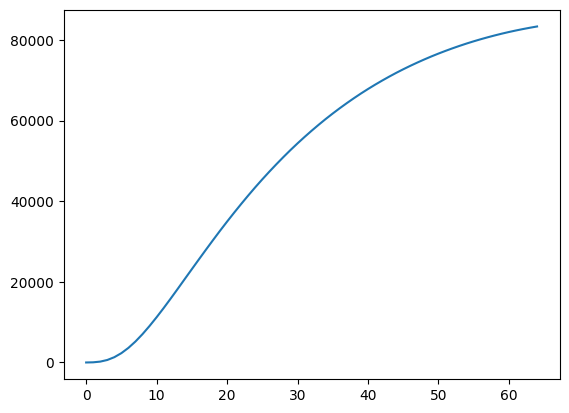

In [58]:
log = run_markov(result_tmat)
inc_unadj = log[2]
plt.plot(inc_unadj[0,0,IDX_DCRC,:].sum(axis=0).cumsum())

In [25]:
from calibration.plots import (
    plot_crc_incidence,
    plot_polyp_incidence,
    plot_transition
)

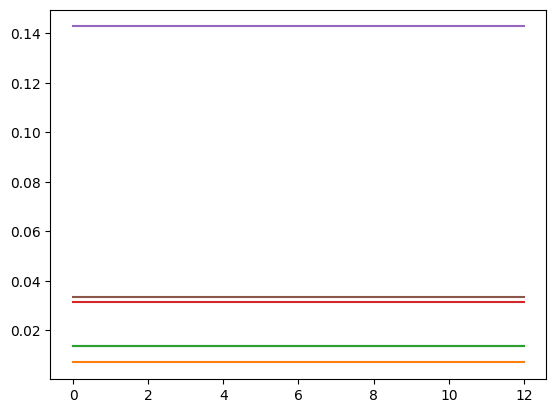

In [51]:
plt.plot(tmatH[0,0,:,0,3])
plt.plot(tmatH[0,0,:,1,3])
plt.plot(tmatH[0,0,:,2,3])
plt.plot(tmatH[0,0,:,3,4])
plt.plot(tmatH[0,0,:,4,5])
plt.plot(tmatH[0,0,:,5,6])

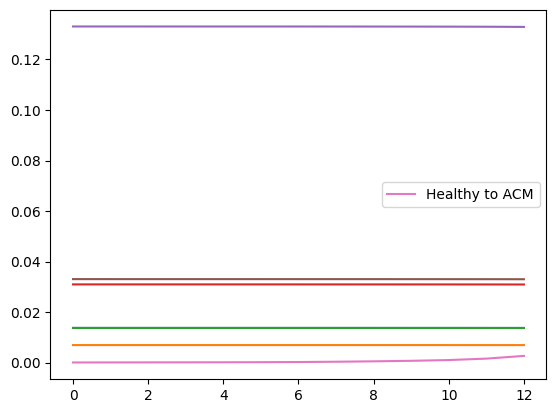

In [55]:
tmatP = hazards_to_probs(tmatH)
plt.plot(tmatP[0,0,:,0,3])
plt.plot(tmatP[0,0,:,1,3])
plt.plot(tmatP[0,0,:,2,3])
plt.plot(tmatP[0,0,:,3,4])
plt.plot(tmatP[0,0,:,4,5])
plt.plot(tmatP[0,0,:,5,6])
plt.plot(tmatP[0,0,:,0,7], label="Healthy to ACM")
plt.legend()